# ハイパーパラメータ最適化結果の可視化

バックグラウンドで実行されたハイパーパラメータ最適化の結果を読み込み、可視化・分析を行います。

## 1. ライブラリのインポート

In [1]:
import glob
import json
import os
import sys
from pathlib import Path

# パスの追加
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

import japanize_matplotlib

japanize_matplotlib.japanize()
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# プロット設定
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 2. 結果ファイルの読み込み

In [2]:
# 結果ディレクトリの設定
output_dir = Path(
    "/home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization/"
)

# 利用可能な結果ファイルを検索
result_files = list(output_dir.glob("hyperparameter_optimization_results_*.json"))
summary_files = list(output_dir.glob("optimization_summary_*.json"))

print(f"結果ディレクトリ: {output_dir}")
print(f"見つかった結果ファイル: {len(result_files)} 個")
print(f"見つかったサマリーファイル: {len(summary_files)} 個")

if result_files:
    # 最新の結果ファイルを自動選択
    latest_result_file = max(result_files, key=lambda x: x.stat().st_mtime)
    print(f"\n最新の結果ファイル: {latest_result_file.name}")

    # 対応するサマリーファイルを探す
    timestamp = latest_result_file.name.split("_")[-1].replace(".json", "")
    corresponding_summary = output_dir / f"optimization_summary_{timestamp}.json"

    if corresponding_summary.exists():
        latest_summary_file = corresponding_summary
        print(f"対応するサマリーファイル: {latest_summary_file.name}")
    else:
        latest_summary_file = (
            max(summary_files, key=lambda x: x.stat().st_mtime)
            if summary_files
            else None
        )
        print(
            f"最新のサマリーファイル: {latest_summary_file.name if latest_summary_file else 'なし'}"
        )
else:
    print("\n結果ファイルが見つかりませんでした。")
    print("先にハイパーパラメータ最適化スクリプトを実行してください:")
    print("python scripts/run_hyperparameter_optimization.py --test")
    latest_result_file = None
    latest_summary_file = None

結果ディレクトリ: /home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization
見つかった結果ファイル: 3 個
見つかったサマリーファイル: 3 個

最新の結果ファイル: hyperparameter_optimization_results_20250701_010552.json
最新のサマリーファイル: optimization_summary_20250701_010552.json


In [3]:
# 結果の読み込み
if latest_result_file:
    print(f"結果ファイルを読み込み中: {latest_result_file.name}")

    with open(latest_result_file, "r", encoding="utf-8") as f:
        optimization_results = json.load(f)

    print(f"読み込み完了: {len(optimization_results)} 件の結果")

    # サマリー情報の読み込み
    if latest_summary_file:
        with open(latest_summary_file, "r", encoding="utf-8") as f:
            optimization_summary = json.load(f)
        print("サマリー情報も読み込み完了")
    else:
        optimization_summary = None
        print("サマリー情報は見つかりませんでした")
else:
    optimization_results = []
    optimization_summary = None

結果ファイルを読み込み中: hyperparameter_optimization_results_20250701_010552.json
読み込み完了: 6 件の結果
サマリー情報も読み込み完了


## 3. 結果の解析とデータフレーム作成

In [4]:
class HyperparameterResultAnalyzer:
    """ハイパーパラメータ最適化結果の解析クラス"""

    def __init__(self, results, summary=None):
        self.results = results
        self.summary = summary
        self.df_summary = None
        self.df_detailed = None

    def create_dataframes(self):
        """解析用データフレームの作成"""
        summary_data = []
        detailed_data = []

        for result in self.results:
            if not result.get("success", False):
                # 失敗した結果はサマリーにのみ記録
                summary_data.append(
                    {
                        "sigma": result["sigma"],
                        "sigma_for_sites": result["sigma_for_sites"],
                        "param_label": f"σ={result['sigma']}, σ_sites={result['sigma_for_sites']}",
                        "success": False,
                        "error": result.get("error", "Unknown error"),
                        "execution_time": result.get("execution_time", 0),
                    }
                )
                continue

            sigma = result["sigma"]
            sigma_for_sites = result["sigma_for_sites"]
            param_label = f"σ={sigma}, σ_sites={sigma_for_sites}"

            # 全時期の統計を集計
            all_aitchison = []
            all_total_variation = []
            all_success_rates = []
            total_successful_trials = 0
            total_trials = 0

            for period, period_result in result["period_results"].items():
                stats = period_result.get("summary_statistics", {})

                if stats.get("n_successful_trials", 0) > 0:
                    # 詳細データ（各試行の結果）
                    for trial in period_result.get("trial_results", []):
                        if trial.get("success", False):
                            detailed_data.append(
                                {
                                    "sigma": sigma,
                                    "sigma_for_sites": sigma_for_sites,
                                    "param_label": param_label,
                                    "period": int(period),
                                    "trial_id": trial.get("trial_id", 0),
                                    "aitchison_distance": trial.get(
                                        "aitchison_distance", np.nan
                                    ),
                                    "total_variation": trial.get(
                                        "total_variation", np.nan
                                    ),
                                    "test_site_id": trial.get("test_site_id", None),
                                }
                            )

                    # 統計データ
                    if "aitchison_distances" in stats:
                        all_aitchison.extend(stats["aitchison_distances"])
                    if "total_variations" in stats:
                        all_total_variation.extend(stats["total_variations"])

                    all_success_rates.append(stats.get("success_rate", 0.0))
                    total_successful_trials += stats.get("n_successful_trials", 0)

                total_trials += period_result.get("n_trials", 0)

            # サマリーデータ
            summary_data.append(
                {
                    "sigma": sigma,
                    "sigma_for_sites": sigma_for_sites,
                    "param_label": param_label,
                    "success": True,
                    "mean_aitchison_distance": np.mean(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "std_aitchison_distance": np.std(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "median_aitchison_distance": np.median(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "mean_total_variation": np.mean(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "std_total_variation": np.std(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "median_total_variation": np.median(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "mean_success_rate": np.mean(all_success_rates)
                    if all_success_rates
                    else 0.0,
                    "overall_success_rate": total_successful_trials / total_trials
                    if total_trials > 0
                    else 0.0,
                    "n_total_trials": len(all_aitchison),
                    "n_total_expected_trials": total_trials,
                    "execution_time": result.get("execution_time", 0),
                }
            )

        self.df_summary = pd.DataFrame(summary_data)
        self.df_detailed = pd.DataFrame(detailed_data)

        return self.df_summary, self.df_detailed

    def print_execution_summary(self):
        """実行サマリーの表示"""
        if self.summary:
            print("=== 実行サマリー ===")
            exec_info = self.summary.get("execution_info", {})
            print(f"テストモード: {exec_info.get('test_mode', 'Unknown')}")
            print(f"総実行時間: {exec_info.get('total_execution_time', 0):.1f}秒")
            print(
                f"パラメータ組み合わせ数: {exec_info.get('n_parameter_combinations', 0)}"
            )
            print(f"評価時期数: {exec_info.get('n_target_periods', 0)}")
            print(f"各時期の試行回数: {exec_info.get('n_trials_per_period', 0)}")

            results_info = self.summary.get("results_summary", {})
            print(f"\n成功率: {results_info.get('success_rate', 0):.3f}")
            print(
                f"成功した組み合わせ: {results_info.get('successful_combinations', 0)}"
            )
            print(f"失敗した組み合わせ: {results_info.get('failed_combinations', 0)}")
        else:
            print("=== 基本統計 ===")
            successful = len([r for r in self.results if r.get("success", False)])
            failed = len([r for r in self.results if not r.get("success", False)])
            print(f"総結果数: {len(self.results)}")
            print(f"成功: {successful}, 失敗: {failed}")
            if len(self.results) > 0:
                print(f"成功率: {successful / len(self.results):.3f}")


# 解析器の作成
if optimization_results:
    analyzer = HyperparameterResultAnalyzer(optimization_results, optimization_summary)

    # データフレームの作成
    df_summary, df_detailed = analyzer.create_dataframes()

    # 実行サマリーの表示
    analyzer.print_execution_summary()

    print("\n=== データフレーム情報 ===")
    print(f"サマリーデータ: {len(df_summary)} パラメータ組み合わせ")
    print(f"詳細データ: {len(df_detailed)} 試行結果")

    # サマリーテーブルの表示
    if len(df_summary) > 0:
        print("\n=== パラメータ評価結果サマリー ===")
        successful_summary = df_summary[df_summary["success"] == True]
        if len(successful_summary) > 0:
            display_cols = [
                "param_label",
                "mean_aitchison_distance",
                "mean_total_variation",
                "overall_success_rate",
                "execution_time",
            ]
            display(successful_summary[display_cols].round(4))
        else:
            print("成功したパラメータ組み合わせがありません")
            print("\n失敗した組み合わせ:")
            display(df_summary[["param_label", "error"]].head())
else:
    print("解析する結果がありません")

=== 実行サマリー ===
テストモード: False
総実行時間: 12913.9秒
パラメータ組み合わせ数: 6
評価時期数: 1
各時期の試行回数: 50

成功率: 1.000
成功した組み合わせ: 6
失敗した組み合わせ: 0

=== データフレーム情報 ===
サマリーデータ: 6 パラメータ組み合わせ
詳細データ: 300 試行結果

=== パラメータ評価結果サマリー ===


,param_label,mean_aitchison_distance,mean_total_variation,overall_success_rate,execution_time
0,"σ=1000, σ_sites=0.001",9.3447,92.1323,1.0,2200.5370
1,"σ=1000, σ_sites=0.01",9.3447,92.1323,1.0,2152.0028
2,"σ=1000, σ_sites=0.1",9.3447,92.1323,1.0,2135.1884
3,"σ=1000, σ_sites=1",9.3447,92.1323,1.0,2147.3249
4,"σ=1000, σ_sites=10",9.3447,92.1323,1.0,2136.4644
5,"σ=1000, σ_sites=100",9.3447,92.1323,1.0,2141.5642


## 4. 箱ひげ図による比較可視化

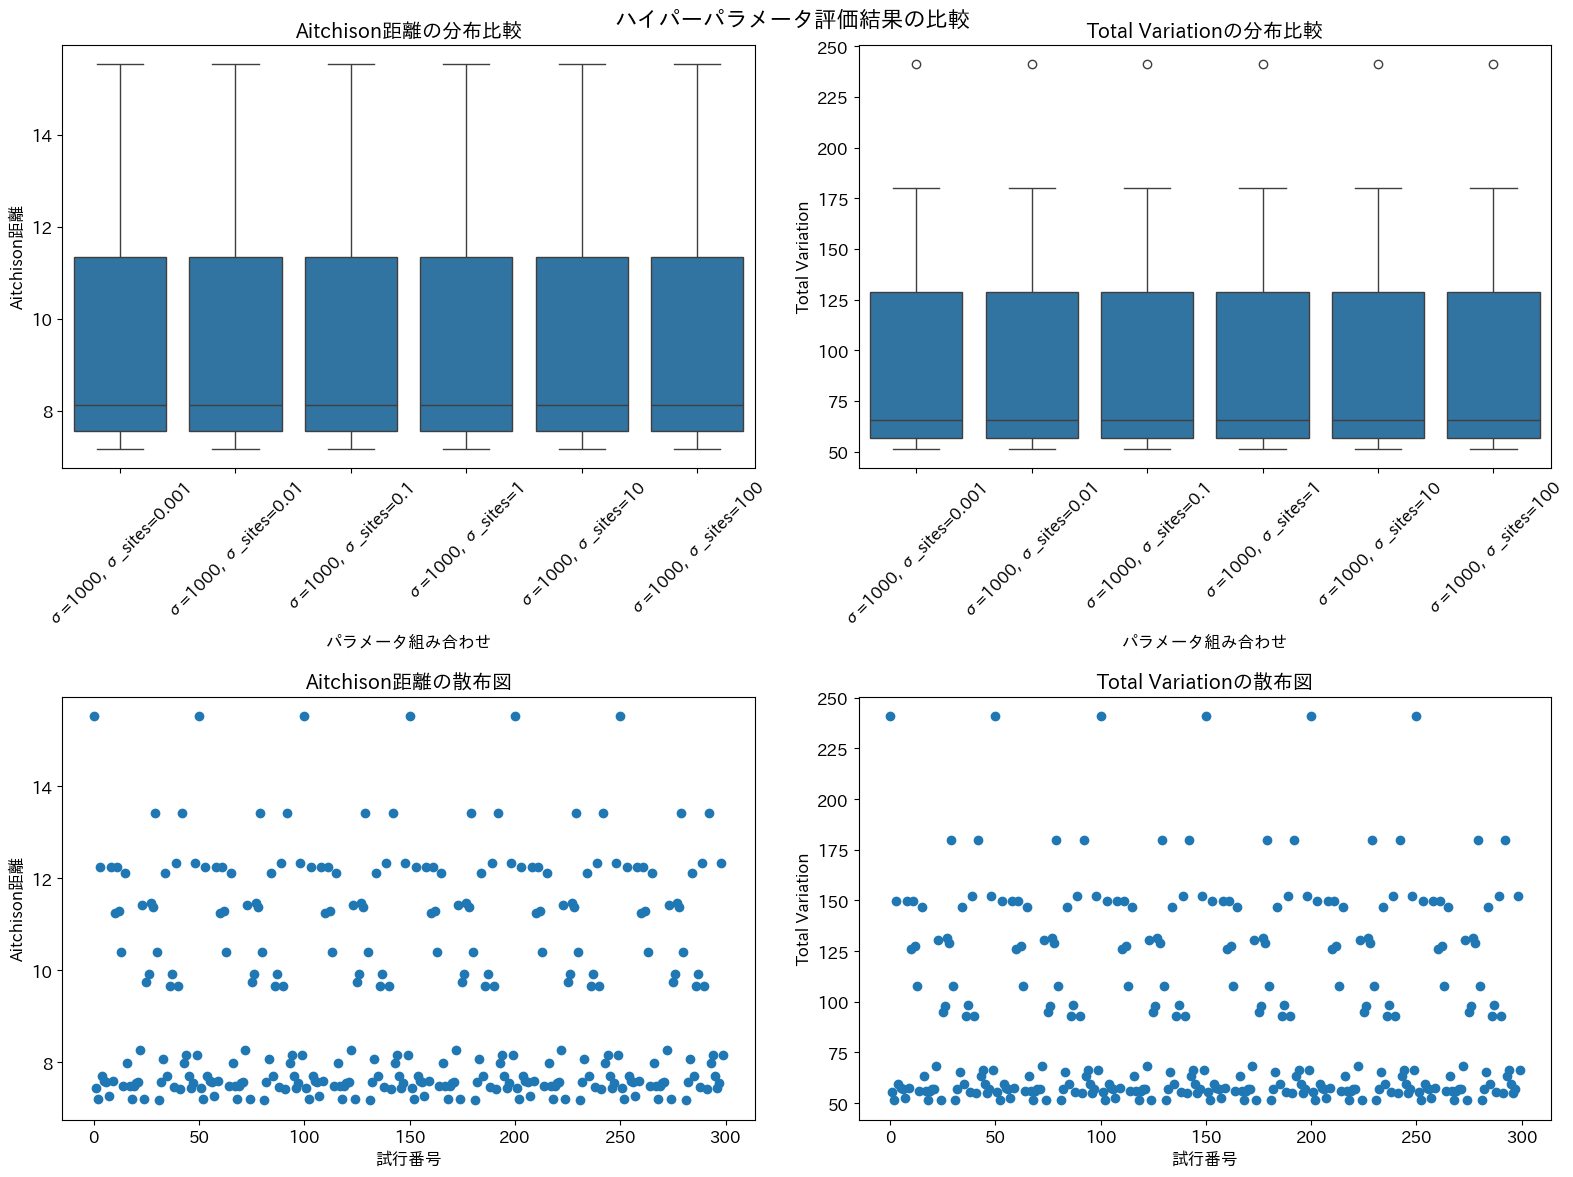

In [5]:
def plot_boxplots(df_detailed, figsize=(16, 12)):
    """箱ひげ図による比較可視化"""
    if len(df_detailed) == 0:
        print("可視化するデータがありません")
        return

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle("ハイパーパラメータ評価結果の比較", fontsize=16, fontweight="bold")

    try:
        # Aitchison距離の箱ひげ図
        sns.boxplot(
            data=df_detailed, x="param_label", y="aitchison_distance", ax=axes[0, 0]
        )
        axes[0, 0].set_title("Aitchison距離の分布比較", fontweight="bold")
        axes[0, 0].set_xlabel("パラメータ組み合わせ")
        axes[0, 0].set_ylabel("Aitchison距離")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # Total Variationの箱ひげ図
        sns.boxplot(
            data=df_detailed, x="param_label", y="total_variation", ax=axes[0, 1]
        )
        axes[0, 1].set_title("Total Variationの分布比較", fontweight="bold")
        axes[0, 1].set_xlabel("パラメータ組み合わせ")
        axes[0, 1].set_ylabel("Total Variation")
        axes[0, 1].tick_params(axis="x", rotation=45)

        # 時期別のAitchison距離（データが十分にある場合のみ）
        if df_detailed["period"].nunique() > 1:
            sns.boxplot(
                data=df_detailed,
                x="param_label",
                y="aitchison_distance",
                hue="period",
                ax=axes[1, 0],
            )
            axes[1, 0].set_title("時期別 Aitchison距離の分布", fontweight="bold")
            axes[1, 0].set_xlabel("パラメータ組み合わせ")
            axes[1, 0].set_ylabel("Aitchison距離")
            axes[1, 0].tick_params(axis="x", rotation=45)
            axes[1, 0].legend(title="時期", bbox_to_anchor=(1.05, 1), loc="upper left")

            # 時期別のTotal Variation
            sns.boxplot(
                data=df_detailed,
                x="param_label",
                y="total_variation",
                hue="period",
                ax=axes[1, 1],
            )
            axes[1, 1].set_title("時期別 Total Variationの分布", fontweight="bold")
            axes[1, 1].set_xlabel("パラメータ組み合わせ")
            axes[1, 1].set_ylabel("Total Variation")
            axes[1, 1].tick_params(axis="x", rotation=45)
            axes[1, 1].legend(title="時期", bbox_to_anchor=(1.05, 1), loc="upper left")
        else:
            # 時期が1つしかない場合は散布図
            axes[1, 0].scatter(
                range(len(df_detailed)), df_detailed["aitchison_distance"]
            )
            axes[1, 0].set_title("Aitchison距離の散布図", fontweight="bold")
            axes[1, 0].set_xlabel("試行番号")
            axes[1, 0].set_ylabel("Aitchison距離")

            axes[1, 1].scatter(range(len(df_detailed)), df_detailed["total_variation"])
            axes[1, 1].set_title("Total Variationの散布図", fontweight="bold")
            axes[1, 1].set_xlabel("試行番号")
            axes[1, 1].set_ylabel("Total Variation")

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

    except Exception as e:
        print(f"箱ひげ図の作成エラー: {e}")
        print("データの内容:")
        print(df_detailed.head())


# 箱ひげ図の作成
if "df_detailed" in locals() and len(df_detailed) > 0:
    plot_boxplots(df_detailed)
else:
    print("箱ひげ図を作成するデータがありません")

## 5. パフォーマンスサマリーの可視化

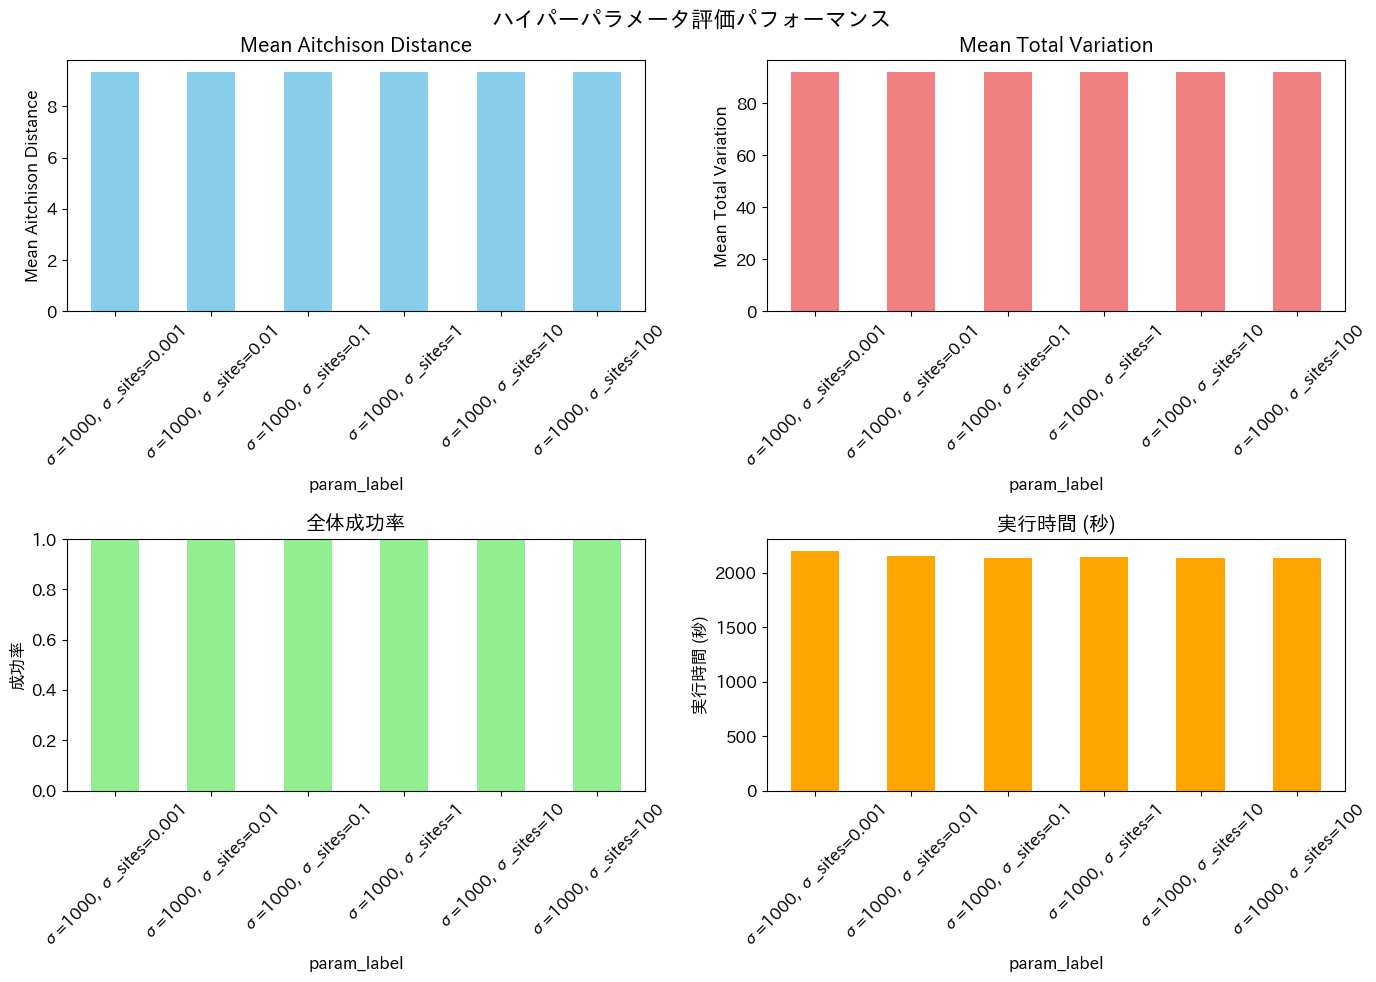

In [6]:
def plot_performance_summary(df_summary, figsize=(14, 10)):
    """パフォーマンスサマリーの可視化"""
    successful_df = df_summary[df_summary["success"] == True]

    if len(successful_df) == 0:
        print("成功したパラメータがないため、パフォーマンス可視化をスキップします")
        return

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle("ハイパーパラメータ評価パフォーマンス", fontsize=16, fontweight="bold")

    try:
        # 平均Aitchison距離
        successful_df.plot(
            x="param_label",
            y="mean_aitchison_distance",
            kind="bar",
            ax=axes[0, 0],
            color="skyblue",
            legend=False,
        )
        axes[0, 0].set_title("Mean Aitchison Distance", fontweight="bold")
        axes[0, 0].set_ylabel("Mean Aitchison Distance")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # 平均Total Variation
        successful_df.plot(
            x="param_label",
            y="mean_total_variation",
            kind="bar",
            ax=axes[0, 1],
            color="lightcoral",
            legend=False,
        )
        axes[0, 1].set_title("Mean Total Variation", fontweight="bold")
        axes[0, 1].set_ylabel("Mean Total Variation")
        axes[0, 1].tick_params(axis="x", rotation=45)

        # 成功率
        successful_df.plot(
            x="param_label",
            y="overall_success_rate",
            kind="bar",
            ax=axes[1, 0],
            color="lightgreen",
            legend=False,
        )
        axes[1, 0].set_title("全体成功率", fontweight="bold")
        axes[1, 0].set_ylabel("成功率")
        axes[1, 0].set_ylim(0, 1)
        axes[1, 0].tick_params(axis="x", rotation=45)

        # 実行時間
        successful_df.plot(
            x="param_label",
            y="execution_time",
            kind="bar",
            ax=axes[1, 1],
            color="orange",
            legend=False,
        )
        axes[1, 1].set_title("実行時間 (秒)", fontweight="bold")
        axes[1, 1].set_ylabel("実行時間 (秒)")
        axes[1, 1].tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

    except Exception as e:
        print(f"パフォーマンス可視化エラー: {e}")
        print("データの内容:")
        print(successful_df.head())


# パフォーマンスサマリーの作成
if "df_summary" in locals() and len(df_summary) > 0:
    plot_performance_summary(df_summary)
else:
    print("パフォーマンス可視化するデータがありません")

## 6. 最適パラメータの決定

In [7]:
def get_best_parameters(df_summary, metric="aitchison_distance"):
    """最適なパラメータの取得"""
    successful_df = df_summary[df_summary["success"] == True]

    if len(successful_df) == 0:
        print("成功したパラメータがありません")
        return None

    if metric == "aitchison_distance":
        best_idx = successful_df["mean_aitchison_distance"].idxmin()
        column_name = "mean_aitchison_distance"
    elif metric == "total_variation":
        best_idx = successful_df["mean_total_variation"].idxmin()
        column_name = "mean_total_variation"
    else:
        raise ValueError(f"Unknown metric: {metric}")

    best_row = successful_df.loc[best_idx]

    print(f"\n=== 最適パラメータ ({metric}基準) ===")
    print(f"sigma: {best_row['sigma']}")
    print(f"sigma_for_sites: {best_row['sigma_for_sites']}")
    print(f"平均{metric}: {best_row[column_name]:.4f}")
    print(f"成功率: {best_row['overall_success_rate']:.3f}")
    print(f"実行時間: {best_row['execution_time']:.1f}秒")

    return {
        "sigma": best_row["sigma"],
        "sigma_for_sites": best_row["sigma_for_sites"],
        "metric_value": best_row[column_name],
        "success_rate": best_row["overall_success_rate"],
    }


# 最適パラメータの決定
if "df_summary" in locals() and len(df_summary) > 0:
    # Aitchison距離基準での最適パラメータ
    try:
        best_aitchison = get_best_parameters(df_summary, metric="aitchison_distance")
    except Exception as e:
        print(f"Aitchison距離基準での最適化エラー: {e}")
        best_aitchison = None

    # Total Variation基準での最適パラメータ
    try:
        best_total_variation = get_best_parameters(df_summary, metric="total_variation")
    except Exception as e:
        print(f"Total Variation基準での最適化エラー: {e}")
        best_total_variation = None

    print("\n=== 推奨パラメータ ===")
    print("両方の指標を総合的に考慮して、最適なパラメータを選択してください。")
    print("一般的には、Aitchison距離が低く、成功率が高いパラメータが推奨されます。")
else:
    print("最適パラメータを決定するデータがありません")
    best_aitchison = None
    best_total_variation = None


=== 最適パラメータ (aitchison_distance基準) ===
sigma: 1000
sigma_for_sites: 0.001
平均aitchison_distance: 9.3447
成功率: 1.000
実行時間: 2200.5秒

=== 最適パラメータ (total_variation基準) ===
sigma: 1000
sigma_for_sites: 0.001
平均total_variation: 92.1323
成功率: 1.000
実行時間: 2200.5秒

=== 推奨パラメータ ===
両方の指標を総合的に考慮して、最適なパラメータを選択してください。
一般的には、Aitchison距離が低く、成功率が高いパラメータが推奨されます。


## 7. 結果のエクスポート

In [ ]:
# 結果のCSV出力
if "df_summary" in locals() and "df_detailed" in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # サマリーCSVの保存
    summary_csv = output_dir / f"analysis_summary_{timestamp}.csv"
    df_summary.to_csv(summary_csv, index=False, encoding="utf-8")
    print(f"サマリーCSVを保存: {summary_csv}")

    # 詳細CSVの保存
    if len(df_detailed) > 0:
        detailed_csv = output_dir / f"analysis_detailed_{timestamp}.csv"
        df_detailed.to_csv(detailed_csv, index=False, encoding="utf-8")
        print(f"詳細CSVを保存: {detailed_csv}")

    # 最適パラメータ情報の保存
    if best_aitchison or best_total_variation:
        # numpy型をPython標準型に変換
        def convert_numpy_types(obj):
            if hasattr(obj, "item"):  # numpy scalar
                return obj.item()
            elif isinstance(obj, dict):
                return {k: convert_numpy_types(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_types(v) for v in obj]
            else:
                return obj

        best_params_info = {
            "analysis_timestamp": timestamp,
            "best_aitchison": convert_numpy_types(best_aitchison),
            "best_total_variation": convert_numpy_types(best_total_variation),
        }

        best_params_file = output_dir / f"best_parameters_{timestamp}.json"
        with open(best_params_file, "w", encoding="utf-8") as f:
            json.dump(best_params_info, f, ensure_ascii=False, indent=2)
        print(f"最適パラメータ情報を保存: {best_params_file}")

print("\n=== 可視化完了 ===")
print("結果ファイルは以下のディレクトリに保存されています:")
print(f"{output_dir}")

サマリーCSVを保存: /home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization/analysis_summary_20250701_061858.csv
詳細CSVを保存: /home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization/analysis_detailed_20250701_061858.csv
最適パラメータ情報を保存: /home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization/best_parameters_20250701_061858.json

=== 可視化完了 ===
結果ファイルは以下のディレクトリに保存されています:
/home/ohta/dev/bayesian_statistics/output/hyperparameter_optimization


## 8. まとめ

このノートブックでハイパーパラメータ最適化の結果を可視化・分析しました。

**主な機能:**
- バックグラウンド実行された結果ファイルの自動読み込み
- 箱ひげ図による候補パラメータの比較
- パフォーマンス指標の可視化
- 最適パラメータの自動決定
- 結果のCSV出力

**次のステップ:**
選択された最適パラメータを使用してModel 3rdの本格的な分析を実行してください。